In [1]:
# Importing libraries for data manipulation
import sqlite3
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import numpy as np

# Importing libraries for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Importing libraries for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

# Importing libraries for classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from py_helpers.pipeline_helper import *
from py_helpers.db_helper import *



In [2]:
df = retrieve_data('./db/WNBA_cleared.db', 'merged')
df.drop(['rank'], axis=1, inplace=True) # to good be true

# Create list with all unique values of the team names
team_names = df['tmID'].unique().tolist()


# label_encoder = LabelEncoder()
# df['tmID'] = label_encoder.fit_transform(df['tmID'])
# df = df.drop(['tmID'], axis=1)

# Shuffling the DataFrame
# df = df.sample(frac=1, random_state=42) 

In [3]:
# Data from the eleveth year
coaches_csv = '../season_11/coaches.csv'
players_teams_csv = '../season_11/players_teams.csv'
teams_csv = '../season_11/teams.csv'

df_coaches = pd.read_csv(coaches_csv)
df_players_teams = pd.read_csv(players_teams_csv)
df_teams = pd.read_csv(teams_csv)

# Merge the dataframes

# coaches: coachID,year,tmID,lgID,stint
# stint -> c_stint

# players_teams: playerID,year,stint,tmID,lgID
# stint -> p_stint

# teams: year,lgID,tmID,franchID,confID,name,arena

# drop coachID, playerID, franchID, confID, name, arena, lgID

df_11 = pd.merge(df_coaches, df_players_teams, on=['year', 'tmID'], how='inner')
df_11 = pd.merge(df_11, df_teams, on=['year', 'tmID'], how='inner')

# Add new teams to the teams name list
new_teams = df_11['tmID'].unique().tolist()
# Add the unique values of each list
team_names = list(set(team_names + new_teams))

#df_11['tmID'] = label_encoder.fit_transform(df_11['tmID'])
#df_11 = df_11.drop(['tmID'], axis=1)
df_11.head()

,coachID,year,tmID,lgID_x,stint_x,playerID,stint_y,lgID_y,lgID,franchID,confID,name,arena
0,aglerbr99w,11,SEA,WNBA,0,birdsu01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
1,aglerbr99w,11,SEA,WNBA,0,cashsw01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
2,aglerbr99w,11,SEA,WNBA,0,ibekwif01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
3,aglerbr99w,11,SEA,WNBA,0,jacksla01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
4,aglerbr99w,11,SEA,WNBA,0,kobryew01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center


In [4]:
len(team_names)
encoder = LabelEncoder()
team_names = encoder.fit_transform(team_names)
print(team_names)

[12 16 18  5 17  9 13  4 11 15  7 14  2 20  3  8  1  0 19  6 10]


In [5]:
# Using the encoder to use in the dataframes wit the team names
df['tmID'] = encoder.transform(df['tmID'])
df_11['tmID'] = encoder.transform(df_11['tmID'])

In [6]:
class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Class - Label Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class - Label Mapping:
ATL: 0
CHA: 1
CHI: 2
CLE: 3
CON: 4
DET: 5
HOU: 6
IND: 7
LAS: 8
MIA: 9
MIN: 10
NYL: 11
ORL: 12
PHO: 13
POR: 14
SAC: 15
SAS: 16
SEA: 17
TUL: 18
UTA: 19
WAS: 20


In [7]:
df_11.loc[df_11['tmID'] == 18]

,coachID,year,tmID,lgID_x,stint_x,playerID,stint_y,lgID_y,lgID,franchID,confID,name,arena
58,edwarte01w,11,18,WNBA,0,ayimmi01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
59,edwarte01w,11,18,WNBA,0,camba01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
60,edwarte01w,11,18,WNBA,0,chriska02w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
61,edwarte01w,11,18,WNBA,0,hodgedo01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
62,edwarte01w,11,18,WNBA,0,holtam01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
63,edwarte01w,11,18,WNBA,0,jacksti02w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
64,edwarte01w,11,18,WNBA,0,jonesma01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
65,edwarte01w,11,18,WNBA,0,lacyje01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
66,edwarte01w,11,18,WNBA,0,lattaiv01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center
67,edwarte01w,11,18,WNBA,0,lennobe01w,0,WNBA,WNBA,DET,WE,Tulsa Shock,BOK Center


In [8]:
# Metrics to be used for evaluation of the model performance
metrics =  {
    'accuracy' : accuracy_score    # Accuracy -> bad with unbalanced data
    # 'precision' : precision_score,  # Precision -> good with unbalanced data (high precision means low false positives)
    # 'recall' : recall_score,        # Recall -> good with unbalanced data (high recall means low false negatives)
    # 'f1' : f1_score,                # F1 -> good with unbalanced data (high f1 means low false positives and false negatives)
    # 'roc_auc' : roc_auc_score       # ROC AUC -> good with unbalanced data (high roc auc means low false positives and false negatives)
}

In [9]:
target = 'playoff'  # The target attribute
seed = 42           # The random seed for the train-test split

In [10]:
# Define the pipeline with different models

# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=seed))
])

# Dictionary of all the models
all_models =  { 'Logistic Regression' : model_lr, 
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [11]:
all_results = { 'sliding': [], 'expanding': [] , 'mixed' : []}

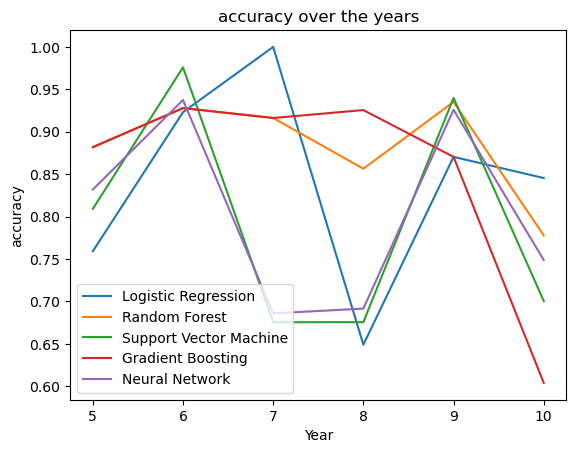

In [12]:
# Sliding window analysis
total_years = 10 # Total number of years that we have data for
window_size = 4 # Maybe test with different window sizes

start = 5

all_results['sliding'] = {}
for model_name, model in all_models.items():
    all_results['sliding'][model_name] = sliding_window_analysis(df, start, total_years, window_size, target, metrics, model)

plot_metrics_for_models(all_results['sliding'], all_models, start, total_years, metrics)

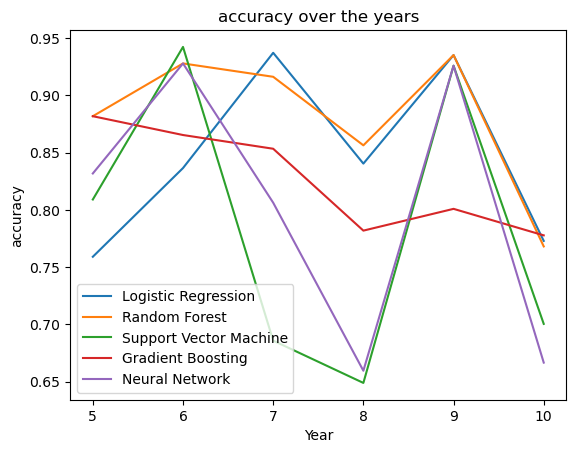

In [13]:
# Expanding window analysis
total_years = 10  # Total number of years that we have data for
start = 5 # Should be higher than 1 because we need to have at least 1 year of training data

all_results['expanding'] = {}
for model_name, model in all_models.items():
    all_results['expanding'][model_name] = expanding_window_analysis(df, start, total_years, target, metrics, model)

plot_metrics_for_models(all_results['expanding'], all_models, start, total_years, metrics)

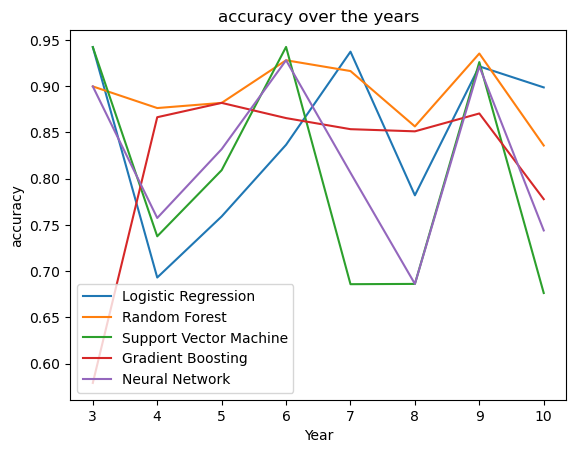

In [14]:
# Mixed window analysis
total_years = 10  # Total number of years that we have data for
start = 3  # Should be higher than 1 because we need to have at least 1 year of training data
start_sliding = 6  # Decide when to start sliding when predicting the 6th year

all_results['mixed'] = {}
for model_name, model in all_models.items():
    all_results['mixed'][model_name] = mixed_window_analysis(df, total_years, start, start_sliding, metrics, model, target)

plot_metrics_for_models(all_results['mixed'], all_models, start, total_years, metrics)

In [15]:
# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500, random_state=seed))  # Increase max_iter
])

tuned_models =  { 'Logistic Regression' : model_lr,
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [16]:
# Hyperparameter grids for each model
param_grid_lr = {
    'classifier__penalty': ['l2'],  # Only 'l2' penalty with lbfgs solver
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


param_grid_svm = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_nn = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'logistic'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

param_grids = {
    'Logistic Regression': param_grid_lr,
    'Random Forest': param_grid_rf,
    'Support Vector Machine': param_grid_svm,
    'Gradient Boosting': param_grid_gb,
    'Neural Network': param_grid_nn
}

In [17]:
def tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding'):
    # Extract metrics for the specified model
    metrics = {'accuracy': accuracy_score}

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Perform sliding window analysis and store results
    if (window_type == 'sliding'):
        results = sliding_window_analysis(df, start, total_years, window_size, target, metrics, grid_search)
    elif (window_type == 'expanding'):
        results = expanding_window_analysis(df, start, total_years, target, metrics, grid_search)
    elif (window_type == 'mixed'):
        results = mixed_window_analysis(df, total_years, start, start_sliding, metrics, grid_search, target)

    # Output the best parameters from the grid search
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Output the mean and standard deviation of accuracy across all windows
    mean_accuracy = np.mean(results['accuracy'])
    std_accuracy = np.std(results['accuracy'])
    print(f"Mean accuracy: {mean_accuracy:.4f}, Standard deviation: {std_accuracy:.4f}")


    return results


Best parameters for Logistic Regression: {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Mean accuracy: 0.7903, Standard deviation: 0.0868
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8825, Standard deviation: 0.0542
Best parameters for Support Vector Machine: {'classifier__C': 0.001, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8170, Standard deviation: 0.1172
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8543, Standard deviation: 0.1141
Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.8

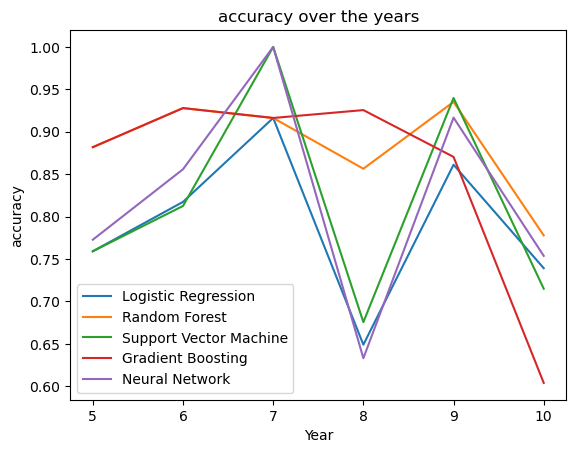

In [18]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


/home/malva2312/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/malva2312/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8445, Standard deviation: 0.0726
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8825, Standard deviation: 0.0542
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8502, Standard deviation: 0.0888
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mean accuracy: 0.8365, Standard deviation: 0.0352
Best parameters for Neural Network: {'classifier__activation': 'logistic', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.8

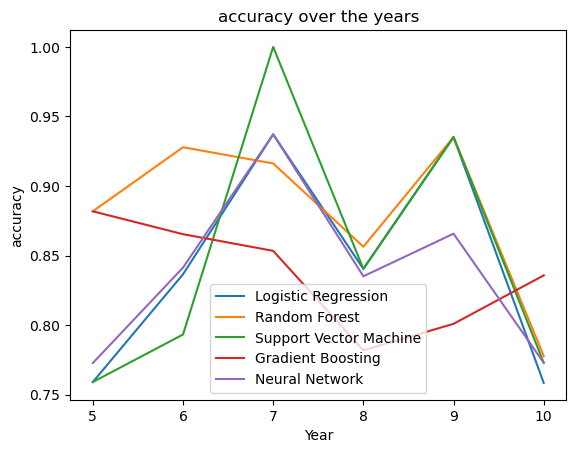

In [19]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='expanding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


Best parameters for Logistic Regression: {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8621, Standard deviation: 0.0612
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mean accuracy: 0.8922, Standard deviation: 0.0371
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Mean accuracy: 0.8225, Standard deviation: 0.0999
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8105, Standard deviation: 0.1209
Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.826

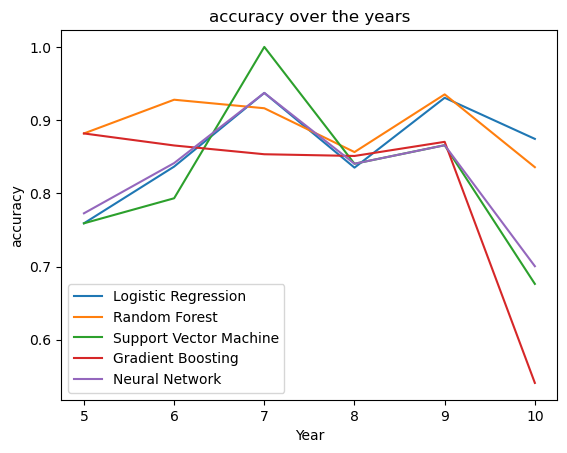

In [20]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='mixed')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


In [21]:
predictions = {}
window_size = 3
start = 6
end = 10

models_to_run = [
    'Logistic Regression'
    #'Random Forest',
    #'Support Vector Machine',
    #'Neural Network'
]



for model_name, pipeline in tuned_models.items():

    results_per_year = {}

    if (model_name not in models_to_run):
        continue

    model_results = {} # Year -> [Data, Result, Predictions]
    w_size = 0
    for year in range(start, end + 1):
        # if side less than window size, expand window
        if (w_size < window_size):
            w_size += 1

        df_train = df[(df['year'] <= year - 1) & (df['year'] >= year - w_size)]
        df_test = df[df['year'] == year]
        if (year == 11):
            df_test = df_11

        X_train = df_train.drop(['playoff'], axis=1)
        y_train = df_train['playoff']

        if (year != 11):
            X_test = df_test.drop(['playoff'], axis=1)
            y_test = df_test['playoff']
        else:
            X_test = df_test
            y_test = None

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)


        #result_df = pd.concat([X_test, pd.Series(y_test, name='y_real'), pd.Series(y_pred, name='y_pred')])

        # concatenate all the info in X_test, y_test, y_pred
        result_df = X_test.copy()
        result_df['y_real'] = y_test
        result_df['y_pred'] = y_pred

        # retriebe the tmID from the label encoder
        result_df['tmID'] = encoder.inverse_transform(result_df['tmID'])
        results_per_year[year] = result_df.groupby(['tmID', 'year']).agg({'y_pred': 'median', 'y_real': 'median'}).reset_index()

    
    # for each yerar in the results_per_year
    # do a table withe the teams and the predictions

    table_df = pd.DataFrame()

    for year, result_df in results_per_year.items():
        
        # Create a column prefix for each year
        col_prefix = f'y_{year}'

        # Rename the columns to include the year
        result_df = result_df.rename(columns={'y_real': f'{year}_real', 'y_pred': f'{year}_pred'})

        # Convert the float values in the 'y_pred' and 'y_real' columns to integers

        # round(players_df[players_df['pos'].isin(['C'])]['height'], 1)
    
        result_df[f'{year}_real'] = round(result_df[f'{year}_real'], 0).astype(bool).astype(int)
        result_df[f'{year}_pred'] = round(result_df[f'{year}_pred'], 0).astype(bool).astype(int)
        
        # Drop the 'year' column as it's already represented in the column names
        result_df = result_df.drop('year', axis=1)

        if table_df.empty:
            # If it's the first iteration, directly assign the result_df to table_df
            table_df = result_df
        else:
            # If not the first iteration, merge on 'tmID'
            table_df = pd.merge(table_df, result_df, on='tmID', how='outer')

    # Sort the DataFrame by 'tmID' for better readability
    table_df = table_df.sort_values(by='tmID').reset_index(drop=True)

    # Display the final table

table_df.head(20)



,tmID,6_pred,6_real,7_pred,7_real,8_pred,8_real,9_pred,9_real,10_pred,10_real
0,ATL,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1,CHA,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,CHI,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,DET,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
5,HOU,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
6,IND,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,LAS,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
8,MIN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NYL,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
